<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-cnn-cancer-detection/blob/main/cnn-cancer-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer detection using CNN

## Introduction

In [22]:
from google.colab import files
from collections import Counter
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation


In [6]:
# get set up with kaggle
files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [7]:
# get data from kaggle
!kaggle competitions download -c histopathologic-cancer-detection > /dev/null
!unzip histopathologic-cancer-detection.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: ./data/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: ./data/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: ./data/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: ./data/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: ./data/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: ./data/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: ./data/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: ./data/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: ./data/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: ./data/train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: ./data/train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: ./data/train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  


### The Problem

Briefly describe the challenge problem and NLP.

The purpose of this project is to participate in the (now closed) Kaggle competition [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection) by creating an algorithm to classify metastatic cancer cells in small images taken from larger digital pathology scans. The Kaggle site describes this data as
" a slightly modified version of the [PatchCamelyon (PCam) benchmark dataset](https://github.com/basveeling/pcam) (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates)."

Identification of cancerous cells by a human is time consuming and expensive. Using ML models as a tool to assist a human in flagging positive classes can reduce the amount of time it would take for a patient to receive treatment, and care providers can focus more of their time on more complicated cases rather than screening out large numbers of negative classes.

### The Data

Describe the size, dimension, structure, etc., of the data.

In [8]:
file_path = './data/train_labels.csv'
df_train = pd.read_csv(file_path)
df_train.head(3)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


## EDA

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

In [14]:
null_count = df_train.isnull().sum()
null_count

,0
id,0
label,0


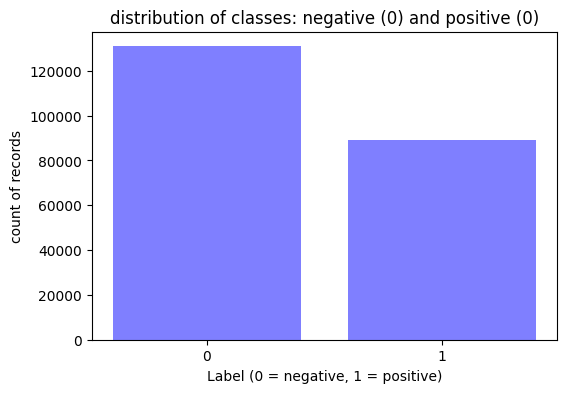

In [37]:
labels, counts = zip(*Counter(df_train['label']).items())
plt.figure(figsize = (6, 4))
plt.bar(labels, counts, color=['blue', 'blue'], alpha = 0.5)
plt.xlabel('Label (0 = negative, 1 = positive)')
plt.ylabel('count of records')
plt.title('distribution of classes: negative (0) and positive (0)')
plt.xticks(labels)
# plt.grid(axis = None)
plt.show()

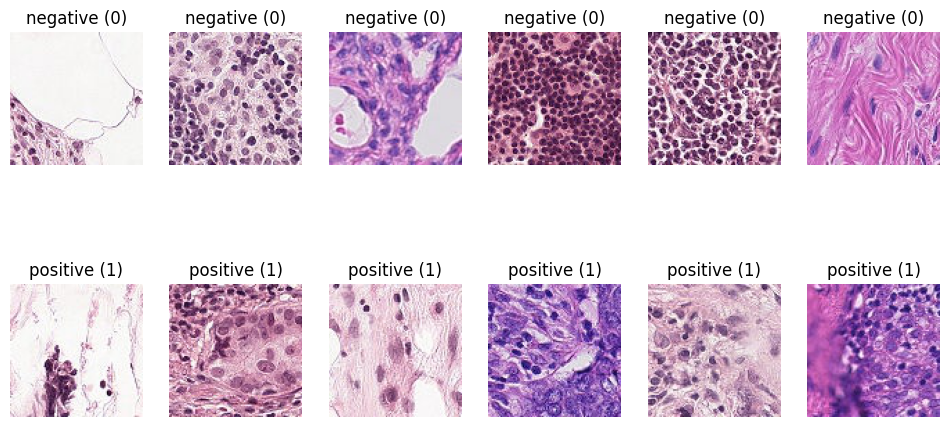

In [39]:
# ref 1.
# add column for image file path
df_train['path'] = df_train['id'].apply(lambda x: os.path.join('./data/train', str(x) + '.tif'))

# separate img by label
images_with_label_0 = df_train[df_train['label'] == 0]
images_with_label_1 = df_train[df_train['label'] == 1]

# enter # to display
num_images_to_display = 6

plt.figure(figsize = (12, 6))

# plot neg class
for i in range(num_images_to_display):
    image = plt.imread(images_with_label_0['path'].iloc[i])
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('negative (0)')

# plot positive class
for i in range(num_images_to_display):
    image = plt.imread(images_with_label_1['path'].iloc[i])
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('positive (1)')

plt.show()

## Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.

## Results and Analysis

### Kaggle competition ranking

Submission file .csv format:

id,label
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
etc.

## Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

## References

1. [This Kaggle notebook](https://www.kaggle.com/code/arcotgautham/msds-histopathologic-cancer-detection-cnn-model)